# Project 1. Denoising Network

In this project, you're going to implement a neural network to denoise images, there are several parts you need to implement to make the whole pipeline complete.

1. Dataset
2. Metrics
3. Networks
4. Training
5. Additional Question

## Dataset

In this project we are going to use an image dataset of 400 grayscale 180*180 images as our dataset, use command below to download the dataset

In [16]:
#!wget https://www.dropbox.com/s/dn6jv1qw5bpdcs9/ImageSet.zip?dl=0 -O ImageSet.zip
#!unzip -q ImageSet.zip

Now you should have a folder called ImageSet, and there're 400 images in it

In [1]:
#!ls ImageSet | wc -l

Now you need to implement two classes, TrainingSet and TestingSet, you should first split your dataset into 350 images and 50 images. TrainingSet should use the 350 images to form a dataset, with each entry being a pair of image tensors, and the first image should be a noisy version of the second original image. In other words, `training_set[i]` should return `[noisy_image(=original_image + noise), original_image]`, and images should be tensors of shape $C\times H\times W$, in this case, $1\times 180\times 180$

TestingSet is the same thing with the remaining 50 images.
1. Please refer to the following code to add noise
    ```python
    def add_noise(img):
        noise = torch.randn(img.size()).mul_(self.sigma/255.0)
        noisy = img + noise
        noisy[torch.where(noisy > 1)] = 1
        noisy[torch.where(noisy < 0)] = 0
        return noisy
    ```
2. Also refer to the following code as how to read images from file to memory
    ```python
    image_path = os.path.join(ROOT_PATH, IMAGE_PATH)
    img = PIL.Image.open(image_path)
    ```

In [2]:
import os
from PIL import Image
import torch
from torchvision import transforms
from tkinter import image_types
import numpy as np

In [3]:
image_folder = "./ImageSet-1/ImageSet" 
images = []
# 遍历文件夹中的所有文件
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"): 
        image_path = os.path.join(image_folder, filename)  
        with Image.open(image_path) as img: 
            #img.show()  # 显示图片（可选）
            images.append(img.copy())
            img.close()

print(len(images))


400


In [4]:
transform = transforms.Compose([
    transforms.ToTensor()  
])
image_tensors = [transform(img) for img in images]

print(image_tensors[0].size())

torch.Size([3, 180, 180])


In [5]:
# implement your TrainingSet and TestingSet here
class TrainingSet:
    def __init__(self,images):
        self.images = images
        self.sigma = 10
        self.trainset = []
        self.dataset()

    def dataset(self):
        for i in range(len(self.images[:350])):
            noise_image = self.add_noise(self.images[i])
            self.trainset.append([noise_image,self.images[i]])
        return self.trainset

    def add_noise(self,img):
        noise = torch.randn(img.size()).mul_(self.sigma/255.0)
        noisy = img + noise
        noisy[torch.where(noisy > 1)] = 1
        noisy[torch.where(noisy < 0)] = 0
        return noisy

    def __len__(self):
        return len(self.trainset)

    def __getitem__(self, idx):
        return self.trainset[idx]




class TestingSet:
    def __init__(self,images):
        self.images = images
        self.sigma = 10
        self.trainset = []
        self.dataset()

    def dataset(self):
        for i in range(len(self.images[-50:])):
            noise_image = self.add_noise(self.images[i])
            self.trainset.append([noise_image,self.images[i]])
        return self.trainset

    def add_noise(self,image):
        noise = torch.randn(image.size()).mul_(self.sigma/255.0)
        noisy = image + noise
        noisy[torch.where(noisy > 1)] = 1
        noisy[torch.where(noisy < 0)] = 0
        return noisy
    def __len__(self):
        return len(self.trainset)

    def __getitem__(self, idx):
        return self.trainset[idx]



# from data import TrainingSet, TestingSet # use this command to use our provided implementation as a placeholder

You can use the following code block to check if your implementation is correct, first, there should be **no error**, second, the shape of image should be **`[1, 180, 180]`**, and finally, in the drawing area, the **left hand side image should be noisier than the right hand side image**, but they should be images of the same thing.

Actual length of training_set: 350
Actual length of testing_set: 50
Shape of image: torch.Size([3, 180, 180])


Text(0.5, 1.0, 'original example')

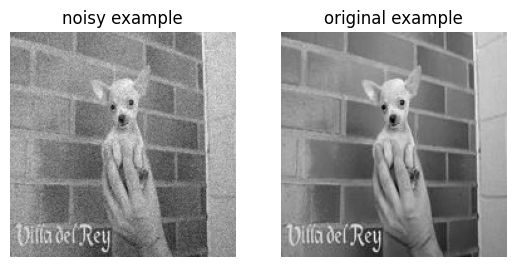

In [6]:
training_set = TrainingSet(image_tensors)
testing_set = TestingSet(image_tensors)
print(f"Actual length of training_set: {len(training_set)}")
print(f"Actual length of testing_set: {len(testing_set)}")
assert len(training_set) == 350
assert len(testing_set) == 50

print(f'Shape of image: {training_set[0][0].shape}')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(training_set[0][0][0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy example')
axes[1].imshow(training_set[0][1][0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original example')

## Metrics
To quantify how noisy an image is compared to the original one, we're going to use PSNR, please implement a function `psnr` to return the psnr score.

Refer to https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio about the formula of PSNR

Note:
1. higher PSNR means noise is relatively smaller, the PSNR of the original image is positive infinity, because the noise is zero.
2. the psnr is a symetric function, meaning the psnr of a noisy image with respect to the original one is the same as the psnr of the original image with respect to the noisy one.

In [7]:
# implement your psnr function
def psnr(original, noisy):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.
    
    Args:
        original (numpy.ndarray): Original image
        noisy (numpy.ndarray): Noisy image
        
    Returns:
        float: PSNR value in dB
    """
    # Ensure both images have the same shape
    if original.shape != noisy.shape:
        raise ValueError("Input images must have the same dimensions")
    
    # Calculate Mean Squared Error (MSE)
    org = 255.0 * original
    nos = 255.0 * noisy
    mse = torch.mean((org - nos) ** 2)
    
    # If MSE is zero, return the maximum possible PSNR
    if mse == 0:
        return float('inf')
    
    # Maximum possible pixel value (assuming 8-bit images)
    max_pixel = 255.0
    
    # Calculate PSNR
    psnr_value = 10 * torch.log10((max_pixel ** 2) / mse)
    
    return psnr_value.item()

# from metrics import psnr # to skip this part

Run the following code to check if the implementation is correct, the expected output should be about 7.96

In [8]:
import torch
test_original = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
test_noisy = torch.tensor([[0.5, 0.6], [0.7, 0.8]])
print(f'PSNR score: {psnr(test_original, test_noisy)}')

PSNR score: 7.958800315856934


And we can calculate the psnr score for the noisy image pair we showed above, the score should be aroud 28, but there could be exception.

In [9]:
print(f'PSNR score for example images: {psnr(training_set[10][1], training_set[10][0])}')

PSNR score for example images: 28.210065841674805


## Network
Now that we got dataset ready and metrics ready, we start preparing the network. You need to define a class `DenoiseNetwork` as your network class.

The goal of your network is to take the noisy image as input and output the predicted **noise**. First of all, the input and the output of the network should have the same size, the main idea is to predict the original image first by going through several CNN layers, and then use the input noisy image to deduct predicted original image to get the noise, the pseudo code should be like:
```python
class DenoiseNetwork(nn.Module):
    def __init__(self):
        define some cnn layers and other necessary components
    
    def forward(self, x):
        predicted_original_image = cnn_network(x)
        noise = x - predicted_original_image
        return noise
```
Then calculate the mean squared error between the predicted noise and the truth noise as our loss, and try to minimize it.

Tips:
1. you can use nn.MSELoss as your loss function
2. Use Adam instead of SGD as your optimizer, initial learning rate set to 0.001
3. Use `torch.nn.init.orthogonal_` to initialize the `weight` of your cnn layers as orthogonal matrices, and use `torch.nn.init.constant_` to fill the `bias` of your cnn layers with `0`s.
4. Try dropout, batchnorm etc. to improve the results (training speed, restored results etc.)

In [10]:
# implement your network DenoiseNetwork
import torch.nn as nn
import torch.nn.init as init

class DenoiseNetwork(nn.Module):
    def __init__(self):
        super(DenoiseNetwork, self).__init__()
        # A simple CNN with several layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Predict the clean image first
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        predicted_clean = self.conv3(out)
        # Subtract to get predicted noise
        predicted_noise = x - predicted_clean
        return predicted_noise

# from model import DenoiseNetwork # to skip this part
net = DenoiseNetwork().cpu()

Here're some basic tests to see if your network can at least run through an example image, this is expected to produce no error.

In [11]:
example_batch = training_set[0][0].unsqueeze(0)
assert net(example_batch.cpu()).shape == example_batch.shape

Now we need a quantitative score to indicate how well a network performs. Previously we have defined the psnr function, but it only calculates psnr of an image pair, we need to calculate two scores to see how well the network denoises, the first is the mean psnr score of all noisy images, which indicates how noisy these unprocessed images are, and then assume we have the network ready, we can use the network to predict the noise, and deduct the noise from the noisy images to produce restored images, then we calculate the mean psnr score of these restored images with respect to the original images, and this score indicate how noisy the restored images are. If everything works out fine, we should be able to observe a higher psnr on the restored images.

You need to define a `mean_psnr` function that takes a dataset and a network as input and calculate the mean psnr scores of original noisy images across the whole dataset and mean psnr of restored images processed by the network.

In [12]:
# implement your mean_psnr function
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

def mean_psnr(testset, net, batch_size=32, device='cpu'):
    # Move network to the specified device
    net = net.to(device)
    net.eval()  # Set to evaluation mode
    
    # Create data loader
    dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    psnr_original_list = []
    psnr_restored_list = []
    
    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            # Get noisy and clean images from the batch
            noisy, clean = batch
            noisy = noisy.to(device)
            clean = clean.to(device)
            
            # Get restored image by subtracting predicted noise from noisy image
            predicted_noise = net(noisy)
            restored = noisy - predicted_noise
            
            # Calculate PSNR for original noisy image
            mse_original = F.mse_loss(noisy, clean, reduction='none')
            psnr_original = 10 * torch.log10(1 / mse_original.mean(dim=[1,2,3]))
            psnr_original_list.extend(psnr_original.cpu().numpy())
            
            # Calculate PSNR for restored image
            mse_restored = F.mse_loss(restored, clean, reduction='none')
            psnr_restored = 10 * torch.log10(1 / mse_restored.mean(dim=[1,2,3]))
            psnr_restored_list.extend(psnr_restored.cpu().numpy())
    
    # Calculate mean PSNR values
    mean_psnr_original = np.mean(psnr_original_list)
    mean_psnr_after = np.mean(psnr_restored_list)
    
    return mean_psnr_original, mean_psnr_after

# from metrics import mean_psnr # to skip this part
# note: to use this mean_psnr function, your network needs to implement a property `device`

We can calculte the mean psnr on `testing_set`

In [13]:
mean_psnr(testing_set, net)

(28.200272, 5.639188)

If your code is correct, you should see the mean psnr of original images should be around 28, and the psnr of network processed images is much smaller, which means, a randomly initialzed network adds even more noise, you should see this by displaying.

Text(0.5, 1.0, 'restored')

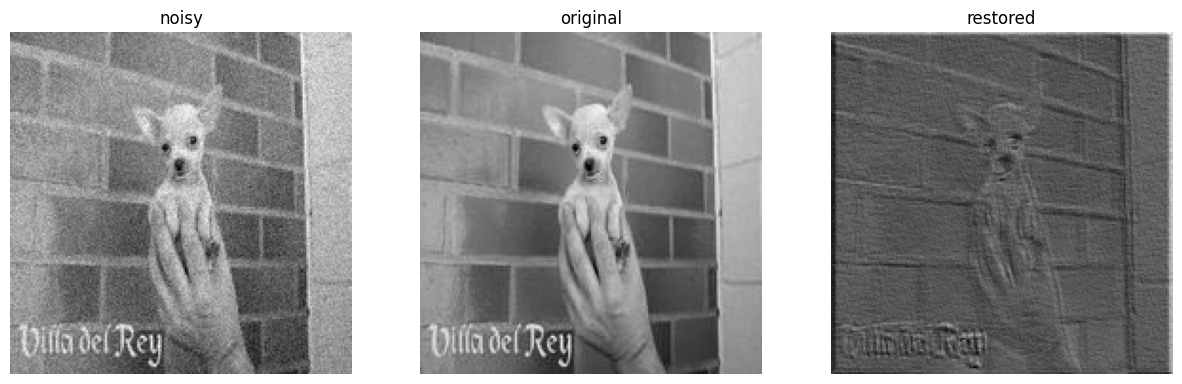

In [14]:
noisy_image, original_image = testing_set[0]
noisy_image = noisy_image.cpu()
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = noisy_image - predicted_noise

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

## Training
Now that we got everything ready, we should start training, in the next section, you need to implement the training process, that includes defining criteria, setting up optimizer, going through several epochs to train the network, during the training, you should also analyze the psnr scores to see how it goes in terms of quantified performance.

Checklist:
1. define dataloader, recommend batch size starting from 32
2. criteria
3. optimizer
4. (optional) consider using functions in torch.optim.lr_scheduler to adjust your learning rate, because smaller learning rate might work better in the later period of training, similar to fine adjustment. Reference: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
5. during each iteration, you need to 1. get the noisy image and the original image 2. calculate predicted noise from network, use MSE to calculate the distance between predicted noise and true noise 3. reset gradients to zero 3. use the distance as loss to backward the network to get gradients 4. perform learning with the gradients using optimizer
6. From time to time (e.g. each epoch), calculate PSNR on testing_set

In [15]:
# implement your training steps
from torch.utils.data import DataLoader
import torch.optim as optim

# fill your code here
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import numpy as np

# 1. Define dataloaders
def get_dataloaders(trainset, testset, batch_size=32):
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# 2. Define training parameters
def train_denoising_network(net, trainset, testset, num_epochs=50, batch_size=32, device='cpu'):
    # Move network to device
    net = net.to(device)
    
    # 1. Create dataloaders
    train_loader, test_loader = get_dataloaders(trainset, testset, batch_size)
    
    # 2. Define loss criterion
    criterion = nn.MSELoss()
    
    # 3. Define optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    # 4. Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Training loop
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        
        for noisy, clean in train_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            
            # 5. Training steps
            # 5.1 Get predictions
            predicted_noise = net(noisy)
            
            # 5.2 Calculate true noise
            true_noise = noisy - clean
            
            # 5.3 Calculate loss
            loss = criterion(predicted_noise, true_noise)
            
            # 5.4 Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        
        # 6. Evaluate on test set
        net.eval()
        with torch.no_grad():
            # Calculate PSNR on test set
            mean_psnr_original, mean_psnr_after = mean_psnr(testset, net, batch_size=batch_size, device=device)
            
            # Print progress
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Loss: {avg_loss:.4f}')
            print(f'Test PSNR (Original): {mean_psnr_original:.2f} dB')
            print(f'Test PSNR (After Denoising): {mean_psnr_after:.2f} dB')
            print('-' * 50)
        
        # Update learning rate based on validation loss
        scheduler.step(avg_loss)
    
    print('Training completed!')
    
    # 绘制 Loss 图（蓝色）
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, num_epochs+1), training_losses, marker='o', color='blue', linewidth=2, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs (Batch Size = 32)")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 绘制 PSNR 图：原始 PSNR用橙色，去噪后 PSNR用蓝色
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, num_epochs+1), psnr_original_list, marker='o', color='orange', linewidth=2, label="Original PSNR")
    plt.plot(range(1, num_epochs+1), psnr_denoised_list, marker='o', color='blue', linewidth=2, label="Denoised PSNR")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.title("Test PSNR over Epochs (Batch Size = 32)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
train_denoising_network(net, training_set, testing_set, num_epochs=50, batch_size=32, device='cpu')

e:\Miniconda\envs\imputer\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Loss: 0.0611
Test PSNR (Original): 28.20 dB
Test PSNR (After Denoising): 17.26 dB
--------------------------------------------------
Epoch 2/50
Loss: 0.0115
Test PSNR (Original): 28.20 dB
Test PSNR (After Denoising): 21.80 dB
--------------------------------------------------
Epoch 3/50
Loss: 0.0042
Test PSNR (Original): 28.20 dB
Test PSNR (After Denoising): 25.60 dB
--------------------------------------------------
Epoch 4/50
Loss: 0.0022
Test PSNR (Original): 28.20 dB
Test PSNR (After Denoising): 28.59 dB
--------------------------------------------------
Epoch 5/50
Loss: 0.0015
Test PSNR (Original): 28.20 dB
Test PSNR (After Denoising): 29.51 dB
--------------------------------------------------
Epoch 6/50
Loss: 0.0012
Test PSNR (Original): 28.20 dB
Test PSNR (After Denoising): 30.30 dB
--------------------------------------------------
Epoch 7/50
Loss: 0.0010
Test PSNR (Original): 28.20 dB
Test PSNR (After Denoising): 31.03 dB
-------------------------------------------

Now that your net is ready, we can re do the demonstration.

Text(0.5, 1.0, 'restored')

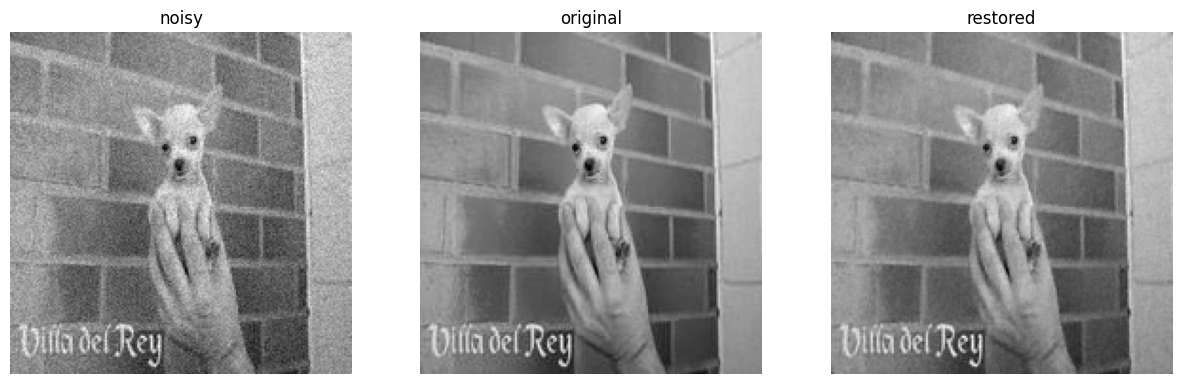

In [29]:
noisy_image, original_image = testing_set[0]
noisy_image = noisy_image.cpu()
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = noisy_image - predicted_noise

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

In [30]:
# Convert PyTorch tensors to NumPy arrays
noisy_np = noisy_image[0].cpu().numpy()
original_np = original_image[0].cpu().numpy()
restored_np = restored_image[0].cpu().detach().numpy()

# Calculate PSNR
# Calculate PSNR with explicit data range
print(f"PSNR (noisy vs original): {psnr(noisy_np, original_np, data_range=1):.2f} dB")
print(f"PSNR (restored vs original): {psnr(restored_np, original_np, data_range=1):.2f} dB")

PSNR (noisy vs original): 28.10 dB
PSNR (restored vs original): 36.14 dB


The network I trained here is a simple 3-layer low number of channel cnn network, and you can see it's already starting to work. Now try adjust some parameters/network structure to make it work even better. Write down your analysis to make a pdf report.

You need to submit two files, this ipynb file and a pdf report with your analysis.

# Additional Question

In this additional question, you need to test on noise different from your training set. In the previous project, you were asked to use Gaussian noise for training, and you also used Gaussian noise when testing.

In this additional question, you are asked to test your trained model using speckle noise. A simple model of Speckle noise is multiplicative noise, which means that the noise is generated by multiplying each pixel value of the image by a random number. This random number is usually drawn from a distribution with a mean of 1 to ensure that noise averaging does not brighten or darken the image.

Below is a Python function that simply implements Speckle noise. This implementation first generates a random noise matrix of the same size as the input image, with values drawn from a normal distribution with mean 1 and standard deviation sigma. This noise matrix is then multiplied by the original image to generate an image with Speckle noise. Finally, the result is constrained to the range 0 to 1 to keep the pixel values valid.

```python
def add_speckle_noise(img, sigma=0.1):
    noise = torch.randn(img.size()) * sigma + 1.0
    noisy_img = img * noise
    noisy_img.clamp_(0, 1)
    return noisy_img
```
You are asked to do the following:

1. First, you are asked to find appropriate sigma values so that the resulting image is visually similar to your training noise. To make your results more general, it is best to choose 3 possible values. (5%)

2. Test your model on these speckle noises using the same model trained above. Compare the PSNR tested on speckle noise with the PSNR tested on Gaussian noise. Show your results in a table. (5%)

3. Finally, draw your conclusion in the pdf report. Can a model trained on Gaussian noise handle speckle noise? To what extent can it be handled? (5%)


Step 1: build the important functions to add speckle noise to the imaga

In [31]:
def add_speckle_noise(img, sigma):
    noise = torch.randn(img.size()) * sigma + 1.0
    noisy_img = img * noise
    noisy_img.clamp_(0, 1)
    return noisy_img

# implement your TrainingSet and TestingSet here
class TrainingSet_speckle:
    def __init__(self,images, sigma):
        self.images = images
        self.sigma = sigma
        self.trainset = []
        self.dataset()

    def dataset(self):
        for i in range(len(self.images[:350])):
            noise_image = add_speckle_noise(self.images[i], self.sigma)
            self.trainset.append([noise_image,self.images[i]])
        return self.trainset


    def __len__(self):
        return len(self.trainset)

    def __getitem__(self, idx):
        return self.trainset[idx]

class TestingSet_speckle:
    def __init__(self,images,sigma):
        self.images = images
        self.sigma = sigma
        self.trainset = []
        self.dataset()

    def dataset(self):
        for i in range(len(self.images[-50:])):
            noise_image = add_speckle_noise(self.images[i], self.sigma)
            self.trainset.append([noise_image,self.images[i]])
        return self.trainset

    def __len__(self):
        return len(self.trainset)

    def __getitem__(self, idx):
        return self.trainset[idx]




Step 2: make a training set and a test set, which are 80% and 20% of the data, respectively. Set the speckle sigma to 0.1.

Actual length of training_set: 350
Actual length of testing_set: 50
Shape of image: torch.Size([3, 180, 180])


Text(0.5, 1.0, 'original example')

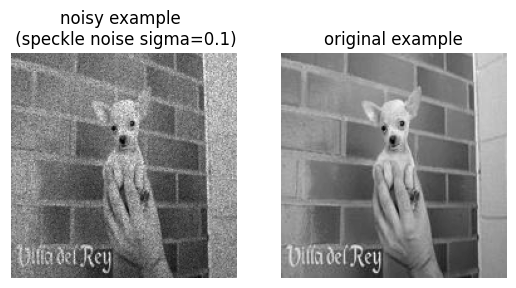

In [36]:
training_set_speckle = TrainingSet_speckle(image_tensors,0.1)
testing_set_speckle = TestingSet_speckle(image_tensors,0.1)
print(f"Actual length of training_set: {len(training_set_speckle)}")
print(f"Actual length of testing_set: {len(testing_set_speckle)}")
assert len(training_set_speckle) == 350
assert len(testing_set_speckle) == 50

print(f'Shape of image: {training_set_speckle[0][0].shape}')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(training_set_speckle[0][0][0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy example \n (speckle noise sigma=0.1)')
axes[1].imshow(training_set_speckle[0][1][0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original example')


Step 3: use the trained model to predict the test data when skeckle noise sigma = 0.1

PSNR (noisy vs original): 25.34 dB
PSNR (restored vs original): 32.94 dB


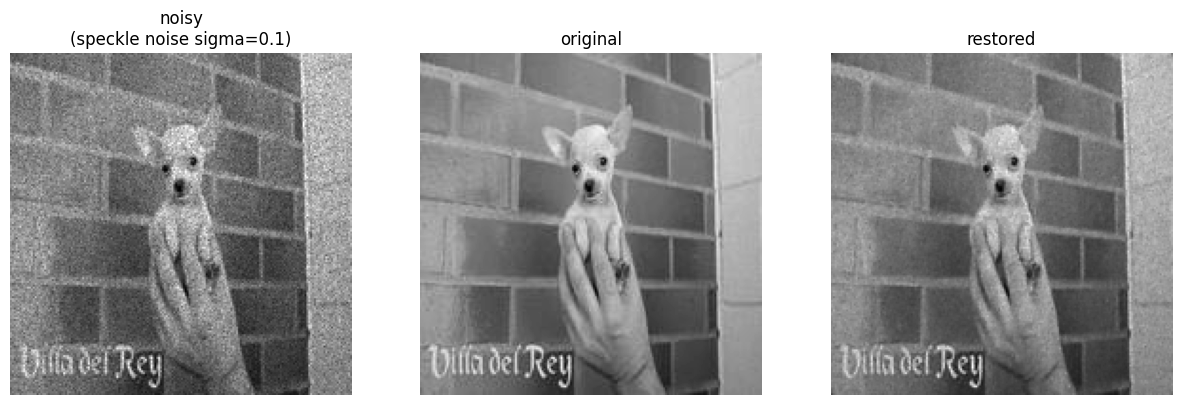

In [37]:
noisy_image, original_image = testing_set_speckle[0]
noisy_image = noisy_image.cpu()
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = noisy_image - predicted_noise

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy\n(speckle noise sigma=0.1)')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

# Convert PyTorch tensors to NumPy arrays
noisy_np = noisy_image[0].cpu().numpy()
original_np = original_image[0].cpu().numpy()
restored_np = restored_image[0].cpu().detach().numpy()

# Calculate PSNR
# Calculate PSNR with explicit data range
print(f"PSNR (noisy vs original): {psnr(noisy_np, original_np, data_range=1):.2f} dB")
print(f"PSNR (restored vs original): {psnr(restored_np, original_np, data_range=1):.2f} dB")

Step 4: make a training set and a test set, which are 80% and 20% of the data, respectively. Set the speckle sigma to 0.15.

Actual length of training_set: 350
Actual length of testing_set: 50
Shape of image: torch.Size([3, 180, 180])


Text(0.5, 1.0, 'original example')

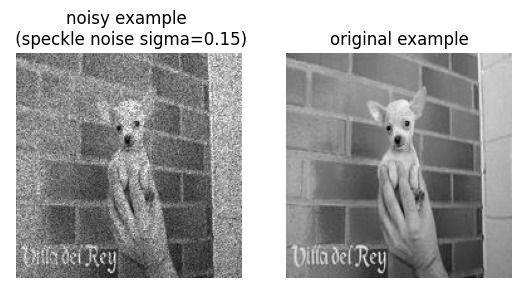

In [38]:
training_set_speckle = TrainingSet_speckle(image_tensors,0.15)
testing_set_speckle = TestingSet_speckle(image_tensors,0.15)
print(f"Actual length of training_set: {len(training_set_speckle)}")
print(f"Actual length of testing_set: {len(testing_set_speckle)}")
assert len(training_set_speckle) == 350
assert len(testing_set_speckle) == 50

print(f'Shape of image: {training_set_speckle[0][0].shape}')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(training_set_speckle[0][0][0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy example \n (speckle noise sigma=0.15)')
axes[1].imshow(training_set_speckle[0][1][0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original example')



Step 5: use the trained model to predict the test data when skeckle noise sigma = 0.15

PSNR (noisy vs original): 21.88 dB
PSNR (restored vs original): 28.59 dB


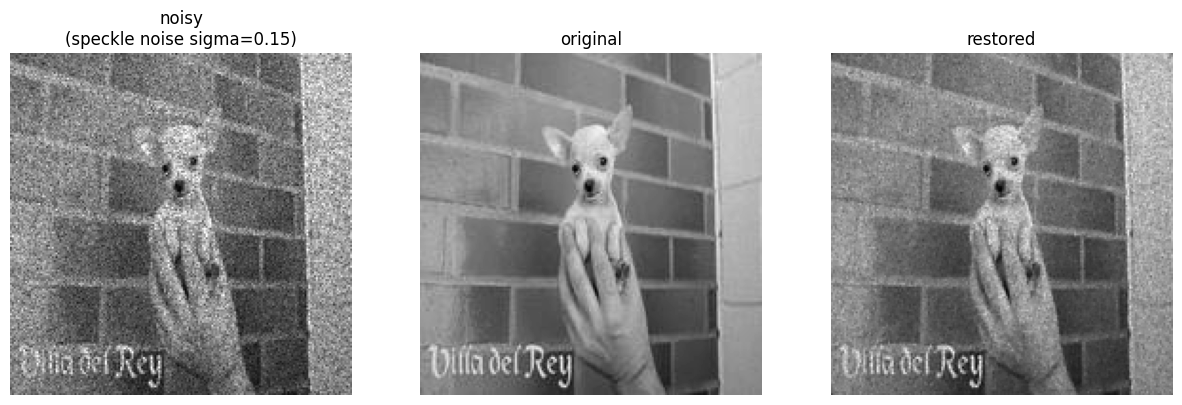

In [39]:
noisy_image, original_image = testing_set_speckle[0]
noisy_image = noisy_image.cpu()
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = noisy_image - predicted_noise

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy\n(speckle noise sigma=0.15)')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

# Convert PyTorch tensors to NumPy arrays
noisy_np = noisy_image[0].cpu().numpy()
original_np = original_image[0].cpu().numpy()
restored_np = restored_image[0].cpu().detach().numpy()

# Calculate PSNR
# Calculate PSNR with explicit data range
print(f"PSNR (noisy vs original): {psnr(noisy_np, original_np, data_range=1):.2f} dB")
print(f"PSNR (restored vs original): {psnr(restored_np, original_np, data_range=1):.2f} dB")

Step 6: make a training set and a test set, which are 80% and 20% of the data, respectively. Set the speckle sigma to 0.05.

Actual length of training_set: 350
Actual length of testing_set: 50
Shape of image: torch.Size([3, 180, 180])


Text(0.5, 1.0, 'original example')

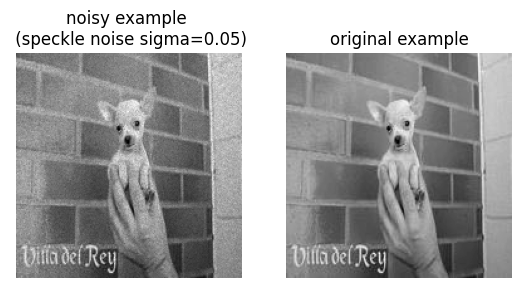

In [40]:
training_set_speckle = TrainingSet_speckle(image_tensors,0.05)
testing_set_speckle = TestingSet_speckle(image_tensors,0.05)
print(f"Actual length of training_set: {len(training_set_speckle)}")
print(f"Actual length of testing_set: {len(testing_set_speckle)}")
assert len(training_set_speckle) == 350
assert len(testing_set_speckle) == 50

print(f'Shape of image: {training_set_speckle[0][0].shape}')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(training_set_speckle[0][0][0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy example \n (speckle noise sigma=0.05)')
axes[1].imshow(training_set_speckle[0][1][0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original example')

Step 7: use the trained model to predict the test data when skeckle noise sigma = 0.05

PSNR (noisy vs original): 31.34 dB
PSNR (restored vs original): 38.89 dB


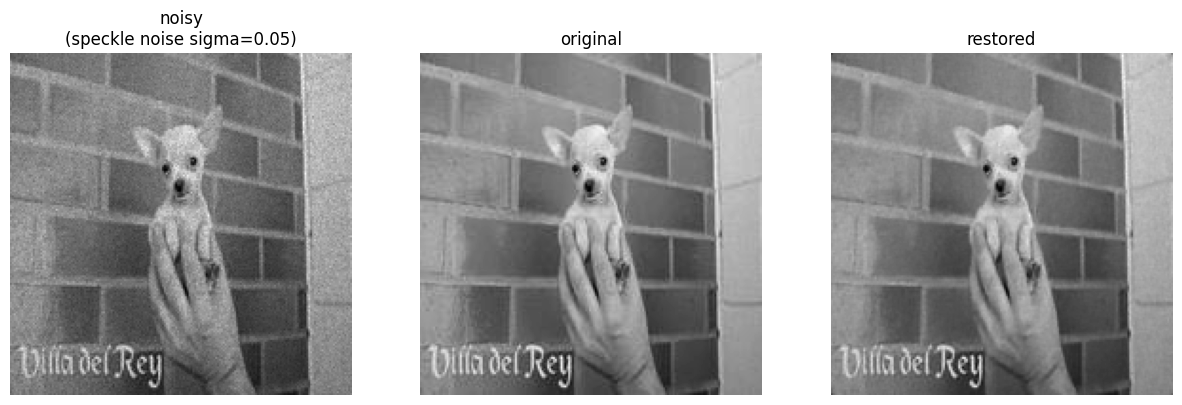

In [41]:
noisy_image, original_image = testing_set_speckle[0]
noisy_image = noisy_image.cpu()
predicted_noise = net(noisy_image.unsqueeze(0)).squeeze(0)
restored_image = noisy_image - predicted_noise

fig, axes = plt.subplots(1,3)
fig.set_figwidth(15)
axes[0].imshow(noisy_image[0].cpu(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('noisy\n(speckle noise sigma=0.05)')
axes[1].imshow(original_image[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('original')
axes[2].imshow(restored_image[0].cpu().detach(), cmap='gray')
axes[2].axis('off')
axes[2].set_title('restored')

# Convert PyTorch tensors to NumPy arrays
noisy_np = noisy_image[0].cpu().numpy()
original_np = original_image[0].cpu().numpy()
restored_np = restored_image[0].cpu().detach().numpy()

# Calculate PSNR
# Calculate PSNR with explicit data range
print(f"PSNR (noisy vs original): {psnr(noisy_np, original_np, data_range=1):.2f} dB")
print(f"PSNR (restored vs original): {psnr(restored_np, original_np, data_range=1):.2f} dB")

# Marking Scheme:


*   Code implementation: 45%


> * Dataset 10%
> * Metrics 5%
> * Network 5% (only 5% because network overlaps with results, you need to adjust the network to improve the results anyway)
> * Training code 10%
> * reasonably good results 15%


*   PDF report: 40%

> * Basic results demonstration (network introduction, denoising results showcase) 15%
> * Analysis and improvements 25% (You're supposed to clarify how do you make the network work, e.g. if you encounter some issues, what do you do to address them)

*   Addtional question: 15%

> * Find appropriate sigma values (5%)
> * Test your model on these speckle noises and report them in a table (5%)
> * Draw your conclusion: Can a model trained on Gaussian noise handle speckle noise? To what extent can it be handled? (5%)
